## Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!pip install scanpy[leiden] louvain
import scanpy as sc
import umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## **Model**

In [13]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, latent_dim, embed_dim, num_classes, num_heads=2, num_layers=2, dropout=0.1):
        """
        A classification model with a transformer layer applied to the encoded features as a sequence.

        Args:
            input_dim (int): Number of features in the input.
            latent_dim (int): Dimensionality of the latent space (used as sequence length).
            embed_dim (int): Dimensionality of token embeddings (d_model for Transformer).
            num_classes (int): Number of output classes.
            num_heads (int): Number of attention heads in the transformer layer.
            num_layers (int): Number of transformer encoder layers.
            dropout (float): Dropout rate in the transformer.
        """
        super(ClassificationModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        # Embedding
        self.feature_projection = nn.Linear(1, embed_dim)  # Expands feature dimension

        # Transformer encoder with batch_first=True
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification
        self.classifier = nn.Linear(latent_dim * embed_dim, num_classes)  # Flattened transformer output

    def forward(self, x):
        # Apply encoder first
        latent = self.encoder(x)  # Shape: (batch_size, latent_dim)
        # print(f"Encoder output shape: {latent.shape}")

        batch_size = latent.size(0)
        latent = latent.unsqueeze(2)  # Reshape to (batch_size, latent_dim, 1)

        # Expand feature representation
        latent = self.feature_projection(latent)  # Shape: (batch_size, latent_dim, embed_dim)

        # Apply transformer (batch_first=True means input shape is (batch, seq_len, d_model))
        transformer_output = self.transformer(latent)  # Shape: (batch_size, latent_dim, embed_dim)

        # Flatten sequence output before classification
        transformer_output = transformer_output.view(batch_size, -1)  # Shape: (batch_size, latent_dim * embed_dim)

        # Classification head
        predicted_labels = self.classifier(transformer_output)  # Shape: (batch_size, num_classes)

        return transformer_output, predicted_labels

## Training and test functions

In [4]:
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs, batch_size):
    """
    Train the given model.

    Parameters:
    - model: The PyTorch model to train.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - X_train_tensor: Training input tensor.
    - y_train_tensor: Training target tensor.
    - num_epochs: Number of epochs to train.
    - batch_size: Batch size for training.

    Returns:
    - epoch_losses: List of average losses per epoch.
    """
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = len(X_train_tensor) // batch_size

        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            # Forward pass
            _, y_predicted = model(batch_X)
            loss = criterion(y_predicted, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / num_batches
        epoch_losses.append(avg_epoch_loss)

    return epoch_losses

def test_model(model, X_test_tensor, y_test_tensor):
    """
    Test the given model and calculate accuracy and classification report.

    Parameters:
    - model: The trained PyTorch model.
    - X_test_tensor: Test input tensor.
    - y_test_tensor: Test target tensor.

    Returns:
    - test_accuracy: Test accuracy.
    - classification_report_str: Classification report as a string.
    """
    model.eval()
    with torch.no_grad():
        latent_vec, y_predicted = model(X_test_tensor)
        test_predictions = torch.argmax(y_predicted, dim=1).cpu().numpy()
        test_accuracy = accuracy_score(y_test_tensor, test_predictions)
        classification_report_str = classification_report(y_test_tensor, test_predictions)

    return test_accuracy, classification_report_str, latent_vec, test_predictions

def plot_loss(epoch_losses):
    """
    Plot training loss over epochs.

    Parameters:
    - epoch_losses: List of average losses per epoch.
    """
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

# Dataset I

## load data

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'
unique lables: ['7MEP', '15Mo', '3Ery', '4Ery', '2Ery', ..., '6Ery', '19Lymph', '12Baso', '18Eos', '11DC']
Length: 19
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c5c3ce871a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


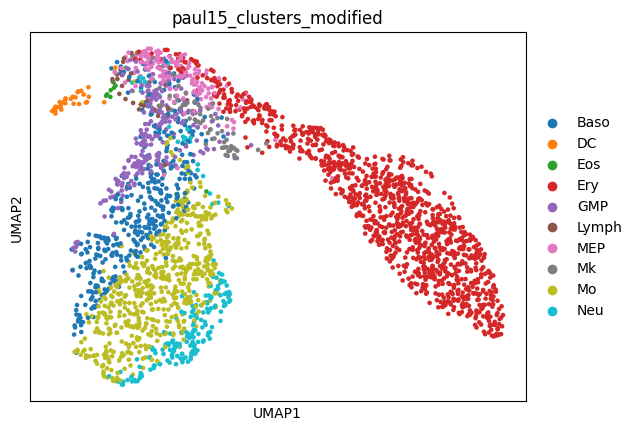

In [5]:
adata=sc.datasets.paul15()
print(adata)

print("unique lables:", adata.obs['paul15_clusters'].unique())

# remove the number before characters to recover cell type
adata.obs['paul15_clusters_modified'] = adata.obs['paul15_clusters'].str.replace(r'^\d+', '', regex=True)

# Compute PCA and UMAP for visualization
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot UMAP with cluster labels
sc.pl.umap(adata, color='paul15_clusters_modified') # legend_loc='on data'

## Process and explore data

In [6]:
label_name = 'paul15_clusters_modified'

##### The model performs better with raw count data without normalisation
# Preprocessing: Normalize, log-transform, and focus on highly variable genes
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=1000)
# adata = adata[:, adata.var['highly_variable']]  # Subset to highly variable genes

# Extract expression data and labels
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X  # Dense array
y = adata.obs[label_name].astype('category').cat.codes  # Encode labels as integers
print(X.shape)
print(X[:5,:5]) ## check the data is raw count data or lognormed data

# Encode labels as integers
y = adata.obs[label_name].astype('category').cat.codes

# Check unique values in the original 'paul15_clusters_modified' column
unique_clusters = adata.obs[label_name].unique()
print("Unique clusters (before encoding):", unique_clusters)

# Check unique encoded labels (after encoding)
unique_encoded_labels = y.unique()
print("Unique encoded labels (after encoding):", unique_encoded_labels)

(2730, 3451)
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 3. 1. 0.]
 [1. 0. 3. 1. 0.]
 [0. 3. 8. 1. 0.]]
Unique clusters (before encoding): ['MEP', 'Mo', 'Ery', 'Neu', 'Baso', 'Mk', 'GMP', 'Lymph', 'Eos', 'DC']
Categories (10, object): ['Baso', 'DC', 'Eos', 'Ery', ..., 'MEP', 'Mk', 'Mo', 'Neu']
Unique encoded labels (after encoding): [6 8 3 9 0 7 4 5 2 1]


## Prepare training and test data

In [7]:
X = np.array(X, dtype=np.float32)  # Ensure all values are floats

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train is a pandas Series
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)    # Assuming y_test is a pandas Series

print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([2184, 3451])
torch.Size([2184])


## Define parameters

In [16]:
input_dim = X_train_tensor.shape[1]
latent_dim = 16
embed_dim = 32
num_classes = len(np.unique(y))
learning_rate = 0.001
batch_size = 32
num_epochs = 20

## Training

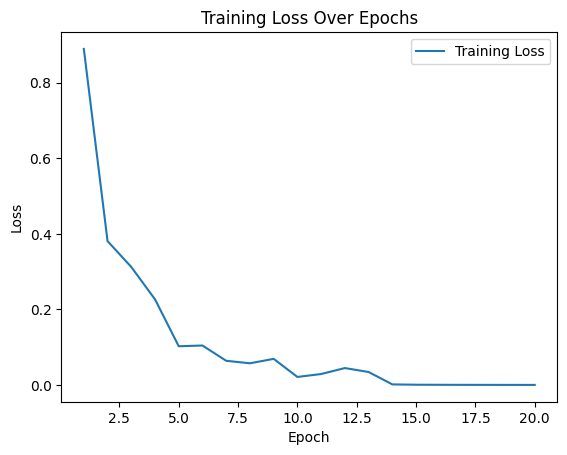

In [17]:
# Initialize model, criterion, and optimizer
model = ClassificationModel(input_dim, latent_dim, embed_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epoch_losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs, batch_size)

# Plot training loss
plot_loss(epoch_losses)


## Test

In [ ]:
# Test the model
test_accuracy, classification_report_str, test_latent, test_predictions = test_model(model, X_test_tensor, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report_str)

Test Accuracy: 0.9286
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        74
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       0.98      1.00      0.99       219
           4       0.86      0.88      0.87        43
           5       1.00      1.00      1.00         6
           6       0.85      0.85      0.85        33
           7       1.00      0.64      0.78        14
           8       0.91      0.94      0.92       112
           9       0.94      0.81      0.87        37

    accuracy                           0.93       546
   macro avg       0.94      0.90      0.91       546
weighted avg       0.93      0.93      0.93       546



## Visualise latent space

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


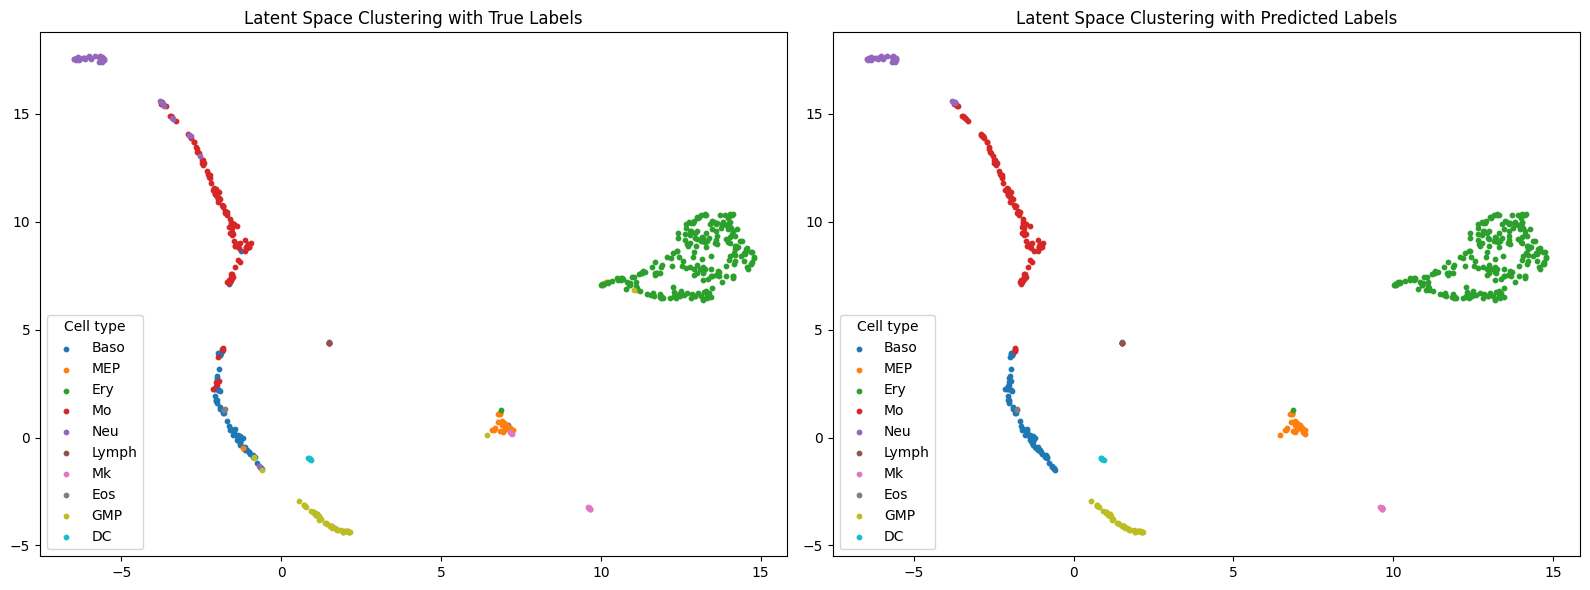

In [ ]:
# convert numeric label to category label
categories = adata.obs[label_name].astype('category').cat.categories
predicted_categories = [categories[label] for label in test_predictions]

true_categories = [categories[label] for label in y_test_tensor.cpu().tolist()]

# Reduce dimensions using UMAP
reducer = umap.UMAP()
latent_2d = reducer.fit_transform(test_latent)

# plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figure size as needed

# Plot 1: Latent space with true labels
for category in set(true_categories):
    idx = [i for i, label in enumerate(true_categories) if label == category]
    axes[0].scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=category, s=10)

axes[0].set_title("Latent Space Clustering with True Labels")
axes[0].legend(title="Cell type")

# Plot 2: Add your second plot (e.g., predicted labels)
for category in set(predicted_categories):
    idx = [i for i, label in enumerate(predicted_categories) if label == category]
    axes[1].scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=category, s=10)

axes[1].set_title("Latent Space Clustering with Predicted Labels")
axes[1].legend(title="Cell type")

# Show the combined plots
plt.tight_layout()
plt.show()


# Dataset II

## Load data

  0%|          | 0.00/3.24M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


AnnData object with n_obs × n_vars = 3934 × 42
    obs: 'exp_groups'
    uns: 'iroot', 'exp_groups_colors'
['HF', 'NP', 'PS', '4SG', '4SFG']
Categories (5, object): ['HF', 'NP', 'PS', '4SG', '4SFG']


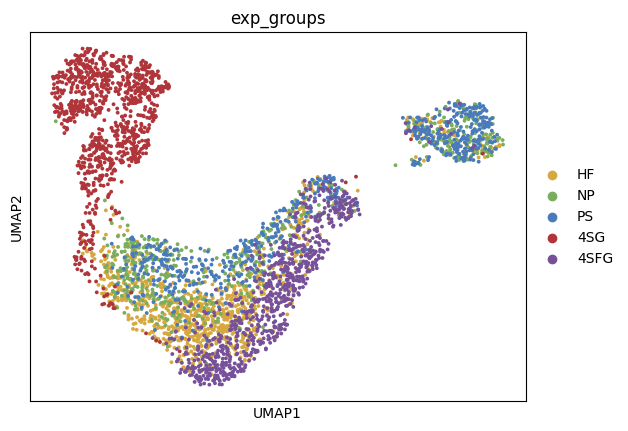

In [ ]:
adata = sc.datasets.moignard15()
print(adata)
print(adata.obs['exp_groups'].unique())  # View predefined cell types

# Compute PCA and UMAP for visualization
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot UMAP with cluster labels
sc.pl.umap(adata, color='exp_groups')

## Process and explore data

In [ ]:
label_name = 'exp_groups'

# Extract expression data and labels
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X  # Dense array
y = adata.obs[label_name].astype('category').cat.codes  # Encode labels as integers
print(X.shape)
print(X[:5,:5]) ## this dataset is normalised data

# Encode labels as integers
y = adata.obs[label_name].astype('category').cat.codes

# Check unique values in the original 'paul15_clusters_modified' column
unique_clusters = adata.obs[label_name].unique()
print("Unique clusters (before encoding):", unique_clusters)

# Check unique encoded labels (after encoding)
unique_encoded_labels = y.unique()
print("Unique encoded labels (after encoding):", unique_encoded_labels)

(3934, 42)
[[-2.598855758 -14.0 1.815101273 -0.096168027 -4.038593128]
 [-14.0 -14.0 -14.0 -3.913417315 -14.0]
 [-14.0 -14.0 -14.0 -4.460141888 -14.0]
 [-14.0 -14.0 -14.0 -14.0 -14.0]
 [-3.907257698 -14.0 0.019497022 -0.715845207 -2.546303348]]
Unique clusters (before encoding): ['HF', 'NP', 'PS', '4SG', '4SFG']
Categories (5, object): ['HF', 'NP', 'PS', '4SG', '4SFG']
Unique encoded labels (after encoding): [0 1 2 3 4]


## Split to training and test

In [ ]:
X = np.array(X, dtype=np.float32)  # Ensure all values are floats

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train is a pandas Series
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)    # Assuming y_test is a pandas Series

## Define parameters

In [ ]:
input_dim = X_train_tensor.shape[1]
latent_dim = 8
num_classes = len(np.unique(y))
learning_rate = 0.001
batch_size = 32
num_epochs = 40

## Training

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


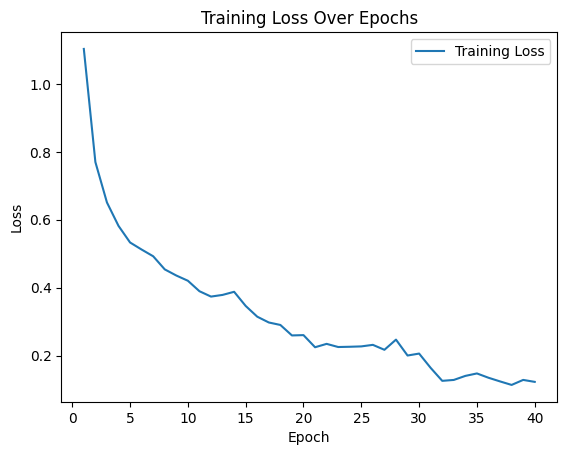

In [ ]:
# Initialize model, criterion, and optimizer
model = ClassificationModel(input_dim, latent_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epoch_losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs, batch_size)

# Plot training loss
plot_loss(epoch_losses)


## Test

In [ ]:
# Test the model
test_accuracy, classification_report_str, test_latent, test_predictions = test_model(model, X_test_tensor, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report_str)

Test Accuracy: 0.7675
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       201
           1       0.54      0.34      0.41       110
           2       0.57      0.78      0.66       125
           3       1.00      0.98      0.99       197
           4       0.85      0.82      0.83       154

    accuracy                           0.77       787
   macro avg       0.74      0.73      0.73       787
weighted avg       0.77      0.77      0.76       787



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


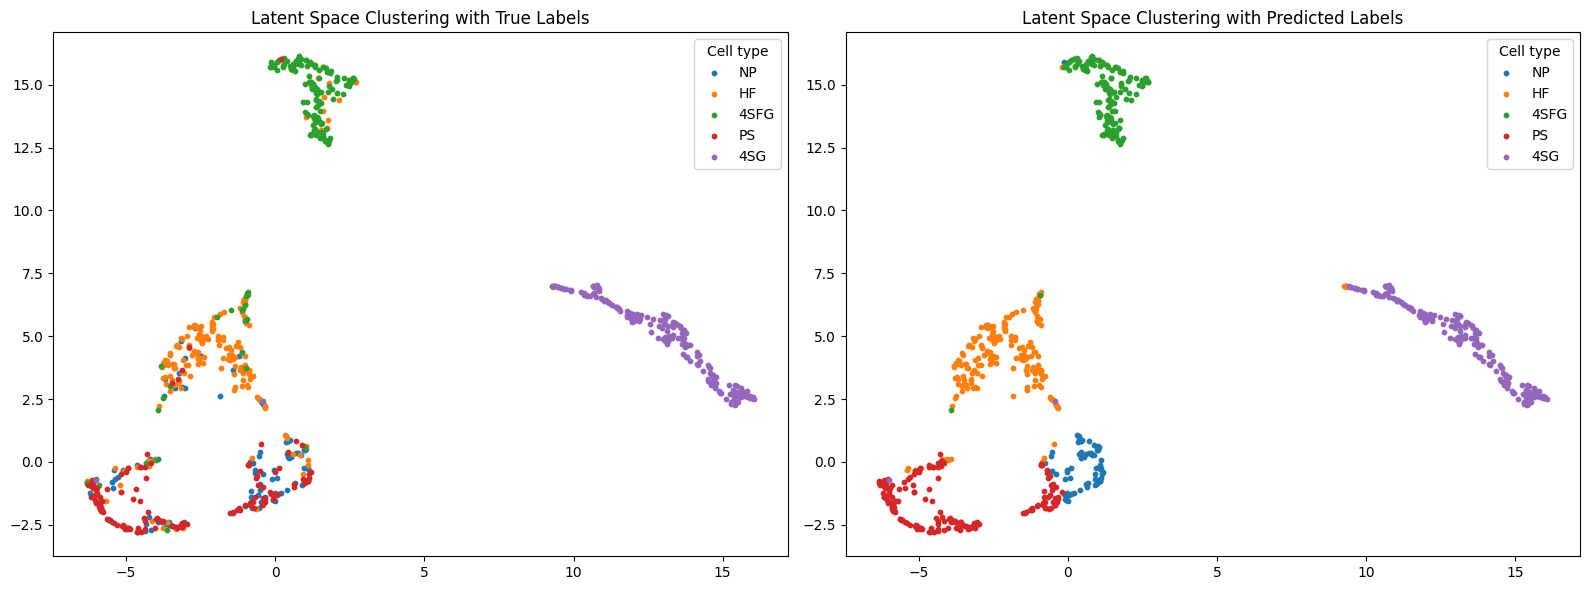

In [ ]:
# convert numeric label to category label
categories = adata.obs[label_name].astype('category').cat.categories
predicted_categories = [categories[label] for label in test_predictions]

true_categories = [categories[label] for label in y_test_tensor.cpu().tolist()]

# Reduce dimensions using UMAP
reducer = umap.UMAP()
latent_2d = reducer.fit_transform(test_latent)

# plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figure size as needed

# Plot 1: Latent space with true labels
for category in set(true_categories):
    idx = [i for i, label in enumerate(true_categories) if label == category]
    axes[0].scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=category, s=10)

axes[0].set_title("Latent Space Clustering with True Labels")
axes[0].legend(title="Cell type")

# Plot 2: Add your second plot (e.g., predicted labels)
for category in set(predicted_categories):
    idx = [i for i, label in enumerate(predicted_categories) if label == category]
    axes[1].scatter(latent_2d[idx, 0], latent_2d[idx, 1], label=category, s=10)

axes[1].set_title("Latent Space Clustering with Predicted Labels")
axes[1].legend(title="Cell type")

# Show the combined plots
plt.tight_layout()
plt.show()
